C:\Users\KHAN SHAHFAHAD\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 10-folds: 91.02% (+/- 0.57%)


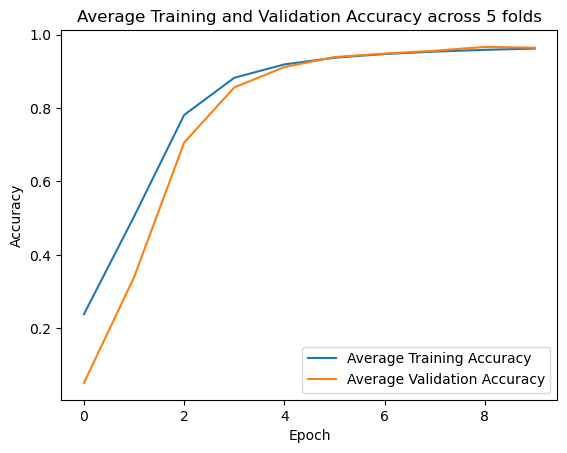

1193/1193 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step


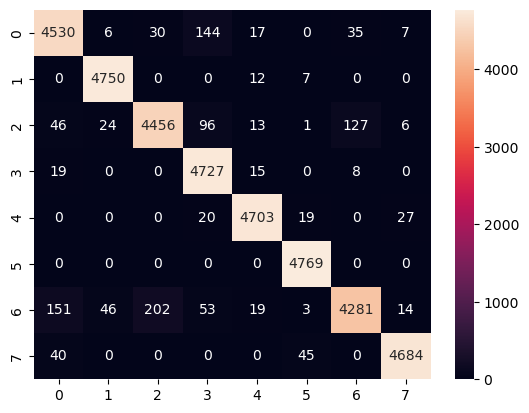

                precision    recall  f1-score   support

         anger       0.95      0.95      0.95      4769
     confusion       0.98      1.00      0.99      4769
disappointment       0.95      0.93      0.94      4769
      distrust       0.94      0.99      0.96      4769
       disgust       0.98      0.99      0.99      4769
   frustration       0.98      1.00      0.99      4769
          fear       0.96      0.90      0.93      4769
       sadness       0.99      0.98      0.99      4769

      accuracy                           0.97     38152
     macro avg       0.97      0.97      0.97     38152
  weighted avg       0.97      0.97      0.97     38152



In [3]:
#GRU Model For dataset...............



import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold

#from keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# 1. Load and Preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the GRU model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))
